<a href="https://colab.research.google.com/github/sheramir/Stock_Research_Agent/blob/main/Stock_Research_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GenAI Capstone Project - Amir Sher**

##Gemini Stock Researcher: An Interactive LangGraph Agent

This project implements an AI-powered chatbot designed to assist users with stock and ETF research through an interactive, guided process.

Built using the LangGraph framework, the agent orchestrates a conversational workflow between the user, a Google Gemini large language model (LLM), and specialized data-retrieval tools.

Key AI techniques employed include prompt engineering to establish the agent's expert persona and strict operational guidelines, the LLM's native tool-calling capabilities to resolve ticker symbols and fetch specific data points (like technical indicators, fundamental data, news, and sentiment analysis), and robust state management via LangGraph to maintain conversational context across multiple turns.

The agent follows a defined agentic workflow that incorporates human-in-the-loop steps for critical tasks like ticker symbol verification, ensuring accuracy and user control while grounding its responses in the data provided by its tools to avoid hallucination and refrain from giving direct financial advice.

## Get Setup

### Install LangGraph for Gemini

In [6]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai

# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

#!pip install -qU 'langgraph>=0.3.22' 'langchain-google-genai==2.1.2' 'langchain-core' # Ensure core is present


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 3.1 MB/s eta 0:00:00


### Import dependancies

In [7]:
!pip show langgraph

Name: langgraph
Version: 0.3.21
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, xxhash
Required-by: 


In [8]:
!pip show langchain-core

Name: langchain-core
Version: 0.3.50
Summary: Building applications with LLMs through composability
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: jsonpatch, langsmith, packaging, pydantic, PyYAML, tenacity, typing-extensions
Required-by: langchain, langchain-google-genai, langchain-text-splitters, langgraph, langgraph-checkpoint, langgraph-prebuilt


In [9]:
import os
import sys
import uuid
import getpass
from typing import TypedDict, Annotated, List, Union
import operator
from IPython.display import Image, display, Markdown

from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
    SystemMessage,
)
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
#from langgraph.prebuilt import ToolExecutor, ToolInvocation


### Get *GOOGLE_API_KEY*

In [10]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

### Define system prompt

In [12]:
SYSTEM_PROMPT = """
You are an expert Stock Research Assistant AI. Your purpose is to help users research publicly traded stocks and ETFs using a defined set of tools. You must strictly adhere to the following workflow and constraints:

**Core Workflow:**

1.  **Initiation:** Start by politely asking the user which specific stock, company, or ETF they would like to research.
2.  **Symbol Resolution & Verification:**
    * Once the user provides input (e.g., "Apple", "Tesla", "SPY", "the S&P 500 ETF"), you MUST use the `resolve_ticker` tool to identify the correct ticker symbol(s).
    * Present the most likely ticker symbol found to the user (e.g., "I found the ticker symbol AAPL for Apple. Is this the symbol you'd like to research?").
    * You MUST receive explicit confirmation from the user for the specific ticker symbol before proceeding. Do not proceed with research until the symbol is confirmed.
3.  **Research Scope Definition:** After confirming the symbol, ask the user what aspect(s) they want to explore. Clearly present these options:
    * Technical Analysis
    * Fundamental Analysis
    * Plot Daily Chart
    * Get News
    * Get Sentiment
    * Produce a Full Report (combining multiple data points)
4.  **Tool Execution & Response:**
    * Based on the user's selection, utilize the appropriate tool(s) listed below to retrieve the requested information for the *confirmed* ticker symbol.
    * Present the information retrieved from the tools clearly and concisely.
    * **Engage with Follow-ups:** Encourage the user to ask follow-up questions about the presented data. Answer these questions accurately, *based solely on the information retrieved from the tools*.
    * **Handle Recommendations Carefully:** If the user asks for recommendations, suggestions, or opinions (e.g., "Should I buy?", "Is this a good investment?"), you MUST:
        * State clearly that you are an AI assistant and **cannot provide financial advice**.
        * You MAY summarize relevant data points gathered from the tools that could *inform* their decision (e.g., "The tool indicates positive sentiment and the P/E ratio is X, which is below the sector average according to the data.").
        * NEVER give a direct buy, sell, or hold recommendation. Ensure any summary or interpretation is strictly tied to the tool data and framed neutrally, avoiding persuasive language.
5.  **Symbol Switching:** The user can request to switch to a different stock or ETF *at any point* during the conversation. If they express this intent (e.g., "Okay, now let's look at Microsoft", "Switch to GOOGL"), acknowledge it politely and restart the workflow from Step 1 (asking for confirmation of the new symbol via Step 2).

**Constraints & Rules:**

* **Tool Reliance:** Your answers and summaries MUST be based *exclusively* on the information retrieved from the available tools.
* **No Hallucination:** DO NOT invent, guess, fabricate, or provide information not present in the tool outputs. If a tool does not provide the information needed to answer a question or fulfill a request, state that clearly (e.g., "My tools did not provide specific data on forward P/E ratio.").
* **No Financial Advice:** Explicitly refuse to give direct financial or investment advice (buy/sell/hold). Frame any data summaries neutrally.
* **Single Symbol Focus:** If the user asks about multiple stocks/ETFs in their initial request (e.g., "Tell me about Apple and Microsoft"), inform them you can only research one symbol at a time. Select the *first* symbol mentioned (e.g., "I can research symbols one at a time. Shall I start with Apple (AAPL)?"), verify it as per Step 2, and proceed.
* **Clarity:** Be clear, professional, and helpful in your interactions.

**Available Tools:**

You have access to the following tools to perform your research tasks:

1.  **`resolve_ticker`**:
    * **Objective:** Takes a company name, partial name, or potential ticker as input and returns the most likely official stock/ETF ticker symbol(s). Essential for Step 2 (Symbol Resolution & Verification).
2.  **`get_technical_analysis`**:
    * **Objective:** Retrieves key technical indicators for the confirmed ticker symbol (e.g., Moving Averages, RSI, MACD, Support/Resistance levels).
3.  **`get_fundamental_data`**:
    * **Objective:** Fetches core fundamental financial data for the confirmed ticker symbol (e.g., P/E Ratio, EPS, Revenue, Market Cap, Dividend Yield).
4.  **`plot_daily_chart`**:
    * **Objective:** Generates a visual plot (or provides data for plotting) of the daily price action for the confirmed ticker symbol over a recent period (e.g., last 3 months, year-to-date). Returns a confirmation message or image data placeholder.
5.  **`get_news`**:
    * **Objective:** Retrieves recent relevant news headlines and summaries associated with the confirmed ticker symbol or underlying company.
6.  **`get_sentiment`**:
    * **Objective:** Analyzes recent news articles or other relevant text data to provide a sentiment score (e.g., positive, negative, neutral) related to the confirmed ticker symbol.
7.  **`generate_full_report`**:
    * **Objective:** Compiles data from multiple tools (`get_technical_analysis`, `get_fundamental_data`, `get_news`, `get_sentiment`) into a consolidated summary report for the confirmed ticker symbol.

Remember to always verify the ticker symbol with the user before using tools 2 through 7. Your primary function is to act as a data conduit and basic interpreter based *only* on the tool outputs, without providing personalized financial advice.
"""


## Building the Agent

In [39]:
# Allow debugging messages using the boolean variable VERBOSE

VERBOSE = False # Set to True to see debug prints, False to hide them

def print_verbose(message):
    if VERBOSE:
        print(message)

### Agent Tools Definitions

In [40]:
# --- Tool Definitions (Dummy Implementations) ---

@tool
def resolve_ticker(query: str) -> str:
    """Find the correct stock/ETF ticker symbol based on company name or user input."""
    print_verbose(f"\n--- TOOL CALL: resolve_ticker ---")
    print_verbose(f"   Query: {query}")

    # Replace with actual API call (e.g., search endpoint of a financial data provider)
    query_lower = query.lower()
    ticker_map = {
        "apple": "AAPL",
        "aapl": "AAPL",
        "microsoft": "MSFT",
        "msft": "MSFT",
        "google": "GOOGL",
        "googl": "GOOGL",
        "alphabet": "GOOGL",
        "tesla": "TSLA",
        "tsla": "TSLA",
        "s&p 500 etf": "SPY",
        "spy": "SPY",
        "spdr s&p 500": "SPY",
    }
    # Simple exact match (case-insensitive)
    if query_lower in ticker_map:
        result = ticker_map[query_lower]
        print_verbose(f"   Result: {result}")
        return result
    # Basic partial match
    for name, ticker in ticker_map.items():
         if query_lower in name:
             result = ticker
             print_verbose(f"   Result (partial match): {result}")
             return result

    print_verbose(f"   Result: Could not resolve")
    return f"Could not definitively resolve ticker for '{query}'. Please provide a more specific name or known ticker, or confirm if this is not a public US stock/ETF."

@tool
def get_technical_analysis(ticker: str) -> str:
    """Retrieve key technical indicators for the confirmed ticker symbol."""
    print_verbose(f"\n--- TOOL CALL: get_technical_analysis ---")
    print_verbose(f"   Ticker: {ticker}")
    # Replace with actual API call
    # Example dummy data
    result = f"""
Technical Analysis for {ticker}:
- Simple Moving Average (SMA 50): $175.20
- Simple Moving Average (SMA 200): $168.50
- Relative Strength Index (RSI 14): 55.8
- MACD (12, 26, 9): Signal line crossover bearish
- Support Level: $170.00
- Resistance Level: $185.00
(Note: Data is illustrative)
"""
    print(f"   Result: [Generated TA data]")
    return result

@tool
def get_fundamental_data(ticker: str) -> str:
    """Fetch core fundamental financial data for the confirmed ticker symbol."""
    print_verbose(f"\n--- TOOL CALL: get_fundamental_data ---")
    print_verbose(f"   Ticker: {ticker}")
    # Replace with actual API call
    # Example dummy data
    result = f"""
Fundamental Data for {ticker}:
- Market Cap: $2.8T
- P/E Ratio (TTM): 29.5
- Earnings Per Share (EPS TTM): $6.10
- Revenue (TTM): $383.3B
- Dividend Yield: 0.55%
(Note: Data is illustrative)
"""
    print(f"   Result: [Generated fundamental data]")
    return result

@tool
def plot_daily_chart(ticker: str) -> str:
    """Generate a daily price chart for the confirmed ticker symbol over a recent period."""
    print_verbose(f"\n--- TOOL CALL: plot_daily_chart ---")
    print_verbose(f"   Ticker: {ticker}")
    # In a real scenario, this would:
    # 1. Fetch historical price data using an API.
    # 2. Use a library like matplotlib or plotly to generate the chart.
    # 3. Save the chart as an image file (e.g., PNG).
    # 4. Return either the file path, image bytes (base64 encoded), or just a confirmation.
    # For this example, we return a confirmation placeholder.
    result = f"Placeholder: A daily chart for {ticker} would be generated here."
    print_verbose(f"   Result: {result}")
    return result # Human node will need to know how to interpret this

@tool
def get_news(ticker: str) -> str:
    """Find recent relevant news headlines and summaries associated with the ticker."""
    print_verbose(f"\n--- TOOL CALL: get_news ---")
    print_verbose(f"   Ticker: {ticker}")
    # Replace with actual News API call
    # Example dummy data
    result = f"""
Recent News for {ticker}:
1. '{ticker} Stock Climbs on Positive Earnings Report' - Source: Financial Times - Summary: Strong quarterly results beat analyst expectations...
2. 'New Product Launch Boosts {ticker} Investor Confidence' - Source: Reuters - Summary: The company unveiled its latest gadget to positive reviews...
3. 'Regulatory Concerns Weigh Down {ticker} Shares Briefly' - Source: Bloomberg - Summary: Investors reacted to potential government scrutiny in the sector...
(Note: Headlines and summaries are illustrative)
"""
    print(f"   Result: [Generated news data]")
    return result

@tool
def get_sentiment(ticker: str) -> str:
    """Analyze recent news/data to determine general sentiment towards the ticker."""
    print_verbose(f"\n--- TOOL CALL: get_sentiment ---")
    print_verbose(f"   Ticker: {ticker}")
    # Replace with actual sentiment analysis (e.g., using NLP on news results or specific APIs)
    # Example dummy data
    sentiments = ["Positive", "Neutral", "Slightly Positive", "Mixed"]
    import random
    sentiment = random.choice(sentiments)
    result = f"Overall sentiment analysis based on recent data for {ticker}: {sentiment}."
    print_verbose(f"   Result: {result}")
    return result

@tool
def generate_full_report(ticker: str) -> str:
    """Combine information from multiple tools into a comprehensive report."""
    print_verbose(f"\n--- TOOL CALL: generate_full_report ---")
    print_verbose(f"   Ticker: {ticker}")
    # This tool would ideally call the other tools internally or ask the LLM
    # to synthesize info based on prior tool calls in the conversation history.
    # For simplicity here, we'll just return a placeholder message.
    # A better approach in LangGraph might be a subgraph that calls other tools.
    result = f"Generating a full report requires calling other tools. Based on available data (if called previously in conversation), a summary would be created here. Please ask for specific sections like 'technical analysis' or 'news' first if they haven't been retrieved yet."
    print_verbose(f"   Result: [Generated report placeholder]")
    return result



# List of all tools

tools = [
    resolve_ticker,
    get_technical_analysis,
    get_fundamental_data,
    plot_daily_chart,
    get_news,
    get_sentiment,
    generate_full_report,
]

# Create a Map from Tool Name to Tool Function
# The @tool decorator adds a '.name' attribute to the function object
tool_map = {tool_func.name: tool_func for tool_func in tools}
print_verbose(f"Tool Map Created: {list(tool_map.keys())}") # Optional: Verify map creation



### AI Model Steup

In [41]:
# Model Setup

# Using Gemini 1.5 Flash for potentially faster interaction
model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    google_api_key = GOOGLE_API_KEY,
    temperature=0.7,
    # safety_settings={ # Adjust as needed, be cautious with financial topics
    #    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    #    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    #    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    #    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    # }
)

# Bind tools to the model
llm_with_tools = model.bind_tools(tools)


### Define AgentState

In [42]:
# Agent State Definition

class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    # query: str # Store last human query - helpful for human node, but messages list is primary
    # response: str # Store last AI response - helpful for human node
    # output_format: str # Hint: 'text', 'markdown', 'image_placeholder' - less crucial for console


### Node Functions

#### Chatbot Node

In [43]:
# Define chatbot node

def chatbot_node(state: AgentState):
    """Calls the Gemini model to generate a response or decide on tool usage."""
    print_verbose("\n--- CHATBOT NODE ---")
    messages = state['messages']
    # Ensure system prompt is included if messages are empty or first message isn't System
    if not messages or not isinstance(messages[0], SystemMessage):
         current_messages = [SystemMessage(content=SYSTEM_PROMPT)] + messages
    else:
        current_messages = messages

    print_verbose(f"   Input Messages: {[m.type for m in current_messages]}") # Print message types
    response = llm_with_tools.invoke(current_messages)
    print_verbose(f"   LLM Response Type: {response.type}")
    if hasattr(response, 'tool_calls') and response.tool_calls:
        print_verbose(f"   Tool Calls: {response.tool_calls}")
    else:
        print_verbose(f"   Response Content: {response.content[:100]}...") # Print start of response

    # Add the AI response (which might contain tool calls) to the messages list
    return {"messages": [response]}

#### Tools Node

In [44]:
# Define tools node

def tools_node(state: AgentState):
    """
    Executes tools requested by the chatbot based on the tool_map.
    """
    print_verbose("\n--- TOOLS NODE ---")
    # Get the last message (which should be the AI message with tool calls)
    last_message = state['messages'][-1]

    # Check if it's an AIMessage with tool_calls
    if not isinstance(last_message, AIMessage) or not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        print_verbose("   No tool calls found in the last message or last message is not AIMessage.")
        # Decide how to handle this - maybe return empty messages or raise an error
        # For robustness, let's return an empty list, assuming the graph logic can handle it
        return {"messages": []}

    tool_calls = last_message.tool_calls
    print_verbose(f"   Found {len(tool_calls)} tool call(s).")

    tool_messages = [] # To store ToolMessage results

    for tool_call in tool_calls:
        tool_name = tool_call['name']
        tool_args = tool_call['args']
        tool_call_id = tool_call['id'] # Get the unique ID for this call

        print_verbose(f"   Processing call ID: {tool_call_id}")
        print_verbose(f"   Tool: {tool_name}")
        print_verbose(f"   Args: {tool_args}")

        # Look up the tool function in our map
        if tool_name not in tool_map:
            print_verbose(f"      Error: Tool '{tool_name}' not found in tool_map.")
            # Report back that the tool was not found
            tool_messages.append(ToolMessage(
                content=f"Error: Tool '{tool_name}' was requested but is not available.",
                tool_call_id=tool_call_id
            ))
            continue # Skip to the next tool call in the list

        # Get the actual function object
        func_to_call = tool_map[tool_name]

        # Execute the tool function
        try:
            # Functions decorated with @tool become Runnable.
            # Call them using .invoke() passing the arguments dictionary.
            output = func_to_call.invoke(tool_args)

            # Convert output to string for the ToolMessage content
            output_content = str(output)
            print_verbose(f"      Success: Executed '{tool_name}'. Output (preview): {output_content[:100]}...")

            # Create the ToolMessage with the output
            tool_messages.append(ToolMessage(
                content=output_content,
                tool_call_id=tool_call_id # Use the specific ID from the call
            ))

        except Exception as e:
            # Handle any errors during tool execution
            error_message = f"Error executing tool {tool_name}: {str(e)}"
            print_verbose(f"      {error_message}")
            tool_messages.append(ToolMessage(
                content=error_message,
                tool_call_id=tool_call_id # Report the error associated with this call ID
            ))

    print_verbose(f"   Generated {len(tool_messages)} ToolMessage(s)")
    # Return the list of ToolMessages to be added to the state
    return {"messages": tool_messages}

#### Human Node

In [45]:
# Define human node

def human_node(state: AgentState):
    """Handles human interaction: displays AI response, gets input."""
    print_verbose("\n--- HUMAN NODE ---")
    last_ai_message = state['messages'][-1]

    # Display the AI's response
    if isinstance(last_ai_message, AIMessage):
        print("\nAssistant:")
        # Basic handling for different potential outputs
        if "Placeholder: A daily chart" in last_ai_message.content:
             print(f"   [Image Placeholder: {last_ai_message.content}]")
        else:
             # Just print text/markdown content for console
             print(f"   {last_ai_message.content}") # Assumes console can handle basic markdown ok

    # Get human input
    while True:
        user_input = input("\nYour Response (or type 'quit' to exit): ")
        if user_input.strip():
            break
        print("Please enter a response.")

    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        print("\nExiting application.")
        # Signal termination by returning a message that the conditional edge can check
        return {"messages": [HumanMessage(content="quit")]}
    else:
        return {"messages": [HumanMessage(content=user_input)]}



### Conditional Routing Logic

In [46]:
# Define conditional routing function

def should_continue(state: AgentState) -> str:
    """Determines the next node to route to."""
    print_verbose("\n--- ROUTING ---")
    last_message = state['messages'][-1]
    print_verbose(f"   Last Message Type: {last_message.type}")

    if isinstance(last_message, AIMessage):
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            print_verbose("   Decision: Route to TOOLS")
            return "tools_node"
        else:
            print_verbose("   Decision: Route to HUMAN")
            return "human_node"
    elif isinstance(last_message, ToolMessage):
        print_verbose("   Decision: Route to CHATBOT")
        return "chatbot_node"
    elif isinstance(last_message, HumanMessage):
        if last_message.content.lower() == 'quit':
            print_verbose("   Decision: END")
            return END
        else:
            print_verbose("   Decision: Route to CHATBOT")
            return "chatbot_node"
    else:
         # Default or error case? Maybe loop back to chatbot or end?
         print_verbose("   Decision: Fallback - Route to CHATBOT")
         return "chatbot_node" # Or END?

### Graph Builder

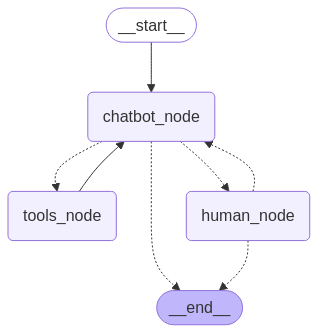

In [47]:
# Build the Graph

graph_builder = StateGraph(AgentState)

# Add nodes
graph_builder.add_node("chatbot_node", chatbot_node)
graph_builder.add_node("tools_node", tools_node)
graph_builder.add_node("human_node", human_node)

# Set entry point
graph_builder.set_entry_point("chatbot_node") # Start with the chatbot's initial message

# Add edges
graph_builder.add_conditional_edges(
    "chatbot_node", # Source node
    should_continue, # Function to determine route
    {
        "tools_node": "tools_node",
        "human_node": "human_node",
        END: END # Should not happen directly from chatbot, but define just in case
    }
)

graph_builder.add_conditional_edges(
    "human_node", # Source node
    should_continue, # Function to determine route based on human input
     {
        "chatbot_node": "chatbot_node",
        END: END # Handle 'quit' command
    }
)

# After tools are executed, always go back to the chatbot
graph_builder.add_edge("tools_node", "chatbot_node")

# Compile the graph
app = graph_builder.compile()

Image(app.get_graph().draw_mermaid_png())

### Execute the Agent

In [48]:
# Run the Graph

print("Starting Stock Research Assistant...")
print("------------------------------------")

# Initial state - start with empty messages, the chatbot node will add the system prompt
initial_state = {
    "messages": [
        SystemMessage(content=SYSTEM_PROMPT),
        HumanMessage(content="hello")  # try '<START>'
    ]
}

# Stream the execution
try:
    # Use stream for potentially long conversations or tool calls
    for event in app.stream(initial_state, stream_mode="values"):
        # event is the full state dictionary at each step
        # The human_node handles the printing and input loop within its execution
        pass # The nodes themselves print debug info

except KeyboardInterrupt:
    print("\nInterrupted by user. Exiting.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

print("------------------------------------")
print("Stock Research Assistant finished.")

Starting Stock Research Assistant...
------------------------------------

Assistant:
   Hello!  I'm ready to assist you with your stock research.  To begin, please tell me which stock, company, or ETF you'd like to research.

Your Response (or type 'quit' to exit): microsoft

Assistant:
   I found the ticker symbol MSFT for Microsoft. Is this the symbol you'd like to research?

Your Response (or type 'quit' to exit): yes

Assistant:
   Great! Now, what aspect(s) of MSFT would you like to explore?  I can help you with:

*   **Technical Analysis:**  Key technical indicators like moving averages and RSI.
*   **Fundamental Analysis:**  Financial data such as P/E ratio, EPS, and revenue.
*   **Plot Daily Chart:** A visual representation of the daily price movements.
*   **Get News:** Recent news headlines and summaries related to Microsoft.
*   **Get Sentiment:**  Analysis of the overall sentiment (positive, negative, or neutral) surrounding MSFT.
*   **Produce a Full Report:** A combined 